In [1]:
import pandas as pd
import spatialpandas as spd
from spatialpandas.io import to_parquet, read_parquet_dask, read_parquet
import geopandas as gpd
import rioxarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import math
import multiprocessing as mp
import sqlite3
import time
import logging
logging.basicConfig(level=logging.INFO)
#import landscan_census as lc

# Landscan to Census Tract Join

Load the landscan 3 arc second rasters

In [ ]:
tx_night, tx_day = lc.load_landscan(
    night_path='/home1/06134/kpierce/landscan/conus_night25.TIF',
    day_path='/home1/06134/kpierce/landscan/conus_day25.TIF'
)

Load the census tract shapefile

In [ ]:
tracts = gpd.read_file('/home1/06134/kpierce/landscan/census_tracts_2019/census_tracts_2019.shp')

Instantiate a custom class (from `landscan_census.py`) for manipulating the landscan and tract data

In [ ]:
ll = lc.Landscan(night_raster=tx_night, day_raster=tx_day, shp=tracts)

Calculate the average population

In [ ]:
ll.average_population()

Perform a spatial sort to speed up the eventual spatial join. The `Landscan.dask_spatial_sort` method saves the output data to the parquet format and then reloads them for lazy computation with dask in downstream steps.

In [ ]:
ll.dask_spatial_sort(savepath='/home1/06134/kpierce/landscan/texas_3arcsecond_spatial_sort.parquet')

In [8]:
ll.average_raster_dask

,position,band,x,y,spatial_ref,night_population,day_population,average_population
npartitions=208,,,,,,,,
,point[float64],int64,float64,float64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


Convert the census tract `geopandas.GeoDataFrame` to a `spatialpandas.GeoDataFrame`

In [9]:
ll.gpd_to_spd()

In [10]:
ll.spdf.head()

,GEOID,geometry
0,48439121609,"Polygon([[-97.233694, 32.671749999999996, -97...."
1,48187210708,"Polygon([[-98.26254, 29.578723999999998, -98.2..."
2,48201550301,"Polygon([[-95.43726699999999, 29.981033, -95.4..."
3,48201550302,"Polygon([[-95.463687, 30.007089999999998, -95...."
4,48157675800,"Polygon([[-96.088854, 29.60166, -96.088912, 29..."


Perform the spatial join on the sorted raster data. This join uses `dask`; the `.compute()` method forces the join calculation on the lazily-loaded spatially sorted data.

In [11]:
rdf = spd.sjoin(ll.average_raster_dask, ll.spdf, how='inner').compute()

In [12]:
rdf.head()

,position,band,x,y,spatial_ref,night_population,day_population,average_population,index_right,GEOID
hilbert_distance,,,,,,,,,,
110794072,"Point([-100.077083433025, 28.12874998448501])",1,-100.077083,28.128750,0,0,0,0,4374,48479001710
110794080,"Point([-100.077916766355, 28.12958331781501])",1,-100.077917,28.129583,0,0,0,0,4374,48479001710
110794084,"Point([-100.077083433025, 28.12958331781501])",1,-100.077083,28.129583,0,0,0,0,4374,48479001710
110794091,"Point([-100.077083433025, 28.13041665114501])",1,-100.077083,28.130417,0,0,0,0,4374,48479001710
110794095,"Point([-100.077916766355, 28.13041665114501])",1,-100.077917,28.130417,0,0,0,0,4374,48479001710


In [13]:
rdf.shape

(95118149, 10)

Over 95 million rows, yikes.

In [14]:
type(rdf)

spatialpandas.geodataframe.GeoDataFrame

Save this computationally expensive dataset

In [15]:
rdf.to_parquet('/home1/06134/kpierce/landscan/texas_3arcsecond_tract_join.parquet')

# Landscan to SVI join on Census Tract FIPS

### Interpolation for persons, housing units, and households

Landscan provides us with a more accurate and more granular understanding of population distribution. The ACS provides us with coarse estimates of population distribution, and counts and percentages of the population falling into certain demographic categories.

We calculate the count and percent of the population in different demographic categories at 30 arcsecond resolution under the following formula:

Let $j$ = { *landscan cells* }, $k$ = { *census tracts* }, and $m$ = { *demographic subset variables from the ACS* }. 

The total population of a landscan cell in a demographic category is N$_{j}$ * percent$_{jkm}$. The SVI-derived populations percents are matched with the landscan cells by a one-to-many point-in polygon join (performed above) that links the landscan cells to the census tracts in which they reside and therefore to the SVI statistics. 

The SVI-derived percent is multiplied by the landscan population under the assumption that the percentage of the population in each demographic category within a landscan cell is the same as the percentage of the population in a demographic category within a census tract.


### Interpolation for persons, housing units, and households - option not used

This is a more complext way to do the calculation...

We calculate the count and percent of the population in different demographic categories at 30 arcsecond resolution under the following formula:

Let $j$ = { *landscan cells* }, $k$ = { *census tracts* }, and $m$ = { *demographic subset variables from the ACS* }. 

The total population of a census tract estimated from landscan data is N$_{k}$ = $\sum$N$_{jk}$ for $j$ landscan cells ${j}$ associated with census tract $k$ (1). 

The population weight (the fraction of the tract population in each landscan cell) is calculated as weight$_{jk}$ = N$_{jk}$ / N$_{k}$ (2). 

Following equations 1 and 2, the total number in each demographic category for each landscan cell is calculated as N$_{jm}$ = N$_{km}$ * weight$_{jk}$ for demographic category $m$ and census tract $k$ (3). 

Finally, the percentage of the population in each demographic category in each landscan cell is calculated as percent$_{jm}$ = min(1, (N$_{jm}$ / N$_{jk}$)) * 100 (4).

Equation 4 accounts for the possibility that a census-derived population estimate in a demographic category may be larger than a landscan derived population total. These anomalies need further investigation, so the uncorrected percentages, which may range greater than 100%, are included in the outputs.

In some cases, only a single landscan cell centroid will fall within a census tract. We do not consider that some fraction of the landscan cell may be outside of these census tracts in conducting the following interpolations.

## Dollars

We do not perform interopolation on variables measured in dollars.

In [2]:
db_name = '/home1/06134/kpierce/protx-db/data/db/cooks_20211006.db'
db_conn = sqlite3.connect(db_name)
db_cursor = db_conn.cursor()

We can calculate the total population of each census tract by summing the population in the landscan cells assigned to that tract, and then calculate the percent of each tract in a landscan cell. However, for simplicity's sake we will not use this value downstream.

In [ ]:
## NOT RUN
tract_totals = rdf[['GEOID', 'average_population']].groupby('GEOID').agg({'average_population': sum}).reset_index()
rdf_tract = pd.merge(rdf, tract_totals, on='GEOID', how='left')
rdf_tract = rdf_tract[rdf_tract['average_population_x'] > 0]
rdf_tract['population_weight'] = rdf_tract['average_population_x'] / rdf_tract['average_population_y']

In [3]:
rdf = read_parquet('/home1/06134/kpierce/landscan/texas_3arcsecond_tract_join.parquet')

Join SVI to the landscan/census tract data.

In [4]:
people = pd.read_sql_query(
    """select * from demographics d \
    join display_data dd on d.DEMOGRAPHICS_NAME = dd.NAME 
    where d.UNITS = 'percent' and \
        d.YEAR = 2019 and \
        d.GEOTYPE = 'tract' and \
        dd.UNITS in ('persons commuting', 'persons') and \
        d.DEMOGRAPHICS_NAME <> 'TOTPOP'
    """, db_conn)

hh = pd.read_sql_query(
    """select * from demographics d \
    join display_data dd on d.DEMOGRAPHICS_NAME = dd.NAME 
    where d.UNITS = 'percent' and \
        d.YEAR = 2019 and \
        d.GEOTYPE = 'tract' and \
        dd.UNITS = 'households' and \
        d.DEMOGRAPHICS_NAME <> 'HH'
    """, db_conn)

hu = pd.read_sql_query(
    """select * from demographics d \
    join display_data dd on d.DEMOGRAPHICS_NAME = dd.NAME 
    where d.UNITS = 'percent' and \
        d.YEAR = 2019 and \
        d.GEOTYPE = 'tract' and \
        dd.UNITS = 'housing units' and \
        d.DEMOGRAPHICS_NAME <> 'HU'
    """, db_conn)

dollars = pd.read_sql_query(
    """select * from demographics d \
    join display_data dd on d.DEMOGRAPHICS_NAME = dd.NAME 
    where d.YEAR = 2019 and \
        d.GEOTYPE = 'tract' and \
        dd.UNITS = 'dollars'
    """, db_conn)

In [5]:
demo_data = pd.concat(
    [
        people[['GEOID', 'DEMOGRAPHICS_NAME', 'VALUE']], 
        hh[['GEOID', 'DEMOGRAPHICS_NAME', 'VALUE']],
        hu[['GEOID', 'DEMOGRAPHICS_NAME', 'VALUE']]
    ]
)
data_wide = pd.pivot(demo_data, index='GEOID', columns='DEMOGRAPHICS_NAME', values='VALUE').reset_index()

In [6]:
calc_columns = data_wide.columns[data_wide.columns != 'GEOID']

Indexing greatly speeds up the join.

In [10]:
rdf_tract_indexed = rdf.set_index('GEOID')

In [11]:
data_wide_indexed = data_wide.set_index('GEOID')

In [12]:
rdf_tract_svi = pd.merge(rdf_tract_indexed, data_wide_indexed, left_index=True, right_index=True, how='left')

In [13]:
rdf_tract_svi.head()

,position,band,x,y,spatial_ref,night_population,day_population,average_population,index_right,10_14_MIN,...,NOHSDP,NOVEH,OTHER_RACE_ALONE,POV,RENTER_OCCUPIED_HU,TWO_OR_MORE_RACES,UNEMP,UNINSUR,WHITE_ALONE,WHITE_ALONE_NOT_HISPANIC_LATINO
GEOID,,,,,,,,,,,,,,,,,,,,,
48001950100,"Point([-95.444583451555, 32.00124996899501])",1,-95.444583,32.00125,0,0,0,0,3978,8.253589,...,8.8,2.9,1.218002,16.3,11.731844,2.353427,2.8,11.1,89.61602,78.922378
48001950100,"Point([-95.445416784885, 32.00124996899501])",1,-95.445417,32.00125,0,0,0,0,3978,8.253589,...,8.8,2.9,1.218002,16.3,11.731844,2.353427,2.8,11.1,89.61602,78.922378
48001950100,"Point([-95.446250118215, 32.00124996899501])",1,-95.446250,32.00125,0,0,0,0,3978,8.253589,...,8.8,2.9,1.218002,16.3,11.731844,2.353427,2.8,11.1,89.61602,78.922378
48001950100,"Point([-95.44708345154501, 32.00124996899501])",1,-95.447083,32.00125,0,0,0,0,3978,8.253589,...,8.8,2.9,1.218002,16.3,11.731844,2.353427,2.8,11.1,89.61602,78.922378
48001950100,"Point([-95.447916784875, 32.00124996899501])",1,-95.447917,32.00125,0,0,0,0,3978,8.253589,...,8.8,2.9,1.218002,16.3,11.731844,2.353427,2.8,11.1,89.61602,78.922378


In [14]:
dollars_wide = pd.pivot(dollars[['GEOID', 'DEMOGRAPHICS_NAME', 'VALUE']], index='GEOID', columns='DEMOGRAPHICS_NAME', values='VALUE').reset_index()

In [16]:
dollars_wide = dollars_wide.set_index('GEOID')

In [17]:
dollars_wide.head()

DEMOGRAPHICS_NAME,MEDIAN_GROSS_RENT_PCT_HH_INCOME,PCI
GEOID,,
48001950100,23.2,27923.0
48001950401,9.0,2357.0
48001950402,16.7,1039.0
48001950500,31.9,17100.0
48001950600,30.7,22549.0


In [18]:
rdf_tract_dollars = pd.merge(rdf_tract_indexed, dollars_wide, left_index=True, right_index=True, how='left')

In [19]:
rdf_tract_dollars.to_parquet('/home1/06134/kpierce/landscan/texas_3arcsec_tract_dollars_join.parquet')

In [20]:
rdf_tract_dollars.head()

,position,band,x,y,spatial_ref,night_population,day_population,average_population,index_right,MEDIAN_GROSS_RENT_PCT_HH_INCOME,PCI
GEOID,,,,,,,,,,,
48001950100,"Point([-95.444583451555, 32.00124996899501])",1,-95.444583,32.00125,0,0,0,0,3978,23.2,27923.0
48001950100,"Point([-95.445416784885, 32.00124996899501])",1,-95.445417,32.00125,0,0,0,0,3978,23.2,27923.0
48001950100,"Point([-95.446250118215, 32.00124996899501])",1,-95.446250,32.00125,0,0,0,0,3978,23.2,27923.0
48001950100,"Point([-95.44708345154501, 32.00124996899501])",1,-95.447083,32.00125,0,0,0,0,3978,23.2,27923.0
48001950100,"Point([-95.447916784875, 32.00124996899501])",1,-95.447917,32.00125,0,0,0,0,3978,23.2,27923.0


In [64]:
rdf_tract_svi.to_parquet('/home1/06134/kpierce/landscan/texas_3arcsec_tract_svi_join.parquet')

## Test conversion to xarray and resolution reduction

A few notes:

- converting the data into a single `xr.Dataset` with multiple variables results in an out-of-memory error
- we can circumvent memory problems without switching to largmem nodes by subsetting the data prior to xarray creation
- each individual xarray can be coarsened along its x and y axis
- the `coarsen` method can be used to calculate the sum of the landscan average population and the sum of the estimated landscan count within a demographic group
- the `coarsen` method argument `boundary='pad'` will make a square extent by padding the excess with `NaN` -- this is the same functionality as `make_square_extent`.
- the `coarsen` method argument `coord_func='mean'` (default) will take the average of the coordinates over which the coarsening window is applied (for this example, the average x coord and average y coord provide the centroid for the landscan cell)
- instead of trying to hold on to the census-derived percentages associated with each GEOID (adding GEOID as a coordinate produces memory errors), we will calculate it as landscan estimate/landscan average pop after coarsening. this is similar to a non-overlapping kernel convolution, as we will averaging across census tracts rather than within.
- for variables related to income (median income as a percent of rent and per capita income), we will take the value average during coarsening. for 30arcsecond cells contained entirely within a census tract, this will retain the original census values. for cells that overlap multiple values, this will be equivalent to an areal weighted average

In [24]:
test_disabl = rdf_tract_svi[['x', 'y', 'average_population', 'DISABL']].reset_index()
test_disabl['DISABL_LANDSCAN_COUNT'] = (test_disabl['average_population'] * (test_disabl['DISABL']/100)) * 100
test_disabl = test_disabl.rename(columns={'DISABL': 'DISABL_CENSUS_PCT'})
test_disabl = test_disabl.set_index(['x', 'y'])
test_disabl_xr = test_disabl.to_xarray()

In [25]:
test_disabl_xr

<xarray.Dataset>
Dimensions:                (x: 15765, y: 12796)
Coordinates:
  * x                      (x) float64 -106.6 -106.6 -106.6 ... -93.51 -93.51
  * y                      (y) float64 25.84 25.84 25.84 ... 36.5 36.5 36.5
Data variables:
    GEOID                  (x, y) object nan nan nan nan nan ... nan nan nan nan
    average_population     (x, y) float64 nan nan nan nan ... nan nan nan nan
    DISABL_CENSUS_PCT      (x, y) float64 nan nan nan nan ... nan nan nan nan
    DISABL_LANDSCAN_COUNT  (x, y) float64 nan nan nan nan ... nan nan nan nan

In [26]:
test_disabl_xr2 = test_disabl_xr.drop_vars(['DISABL_CENSUS_PCT', 'GEOID'])

In [27]:
test_disabl_xr2_30arcsec = test_disabl_xr2.coarsen(
    boundary='pad',
    x=10,
    y=10,
    coord_func='mean'
).sum().compute()

In [28]:
test_disabl_xr2_30arcsec

<xarray.Dataset>
Dimensions:                (x: 1577, y: 1280)
Coordinates:
  * x                      (x) float64 -106.6 -106.6 -106.6 ... -93.52 -93.51
  * y                      (y) float64 25.84 25.85 25.86 ... 36.48 36.49 36.5
Data variables:
    average_population     (x, y) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DISABL_LANDSCAN_COUNT  (x, y) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

The state-wide totals are almost equal:

In [29]:
print(sum(test_disabl_xr2_30arcsec['average_population'].values.flatten()))
print(np.nansum(test_disabl_xr['average_population'].values.flatten()))

28660297.0
28660297.0


In [30]:
np.testing.assert_almost_equal(
    np.nansum(test_disabl_xr2_30arcsec['average_population'].values.flatten()),
    np.nansum(test_disabl_xr['average_population'].values.flatten())
)

In [31]:
print(sum(test_disabl_xr2_30arcsec['DISABL_LANDSCAN_COUNT'].values.flatten()))
print(np.nansum(test_disabl_xr['DISABL_LANDSCAN_COUNT'].values.flatten()))

328346522.60000205
328346522.59999895


In [32]:
disbl_pct = test_disabl_xr2_30arcsec['DISABL_LANDSCAN_COUNT'] / test_disabl_xr2_30arcsec['average_population']

In [33]:
disbl_pct

<xarray.DataArray (x: 1577, y: 1280)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 -106.6 -106.6 -106.6 -106.6 ... -93.53 -93.52 -93.51
  * y        (y) float64 25.84 25.85 25.86 25.87 ... 36.47 36.48 36.49 36.5

In [34]:
test_disabl_xr2_30arcsec['DISABL_LANDSCAN_PCT_2'] = disbl_pct
test_disabl_xr2_30arcsec['DISABL_LANDSCAN_PCT_3'] = disbl_pct

In [35]:
test_disabl_xr2_30arcsec

<xarray.Dataset>
Dimensions:                (x: 1577, y: 1280)
Coordinates:
  * x                      (x) float64 -106.6 -106.6 -106.6 ... -93.52 -93.51
  * y                      (y) float64 25.84 25.85 25.86 ... 36.48 36.49 36.5
Data variables:
    average_population     (x, y) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DISABL_LANDSCAN_COUNT  (x, y) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DISABL_LANDSCAN_PCT_2  (x, y) float64 nan nan nan nan ... nan nan nan nan
    DISABL_LANDSCAN_PCT_3  (x, y) float64 nan nan nan nan ... nan nan nan nan

In [36]:
test_disabl_xr2_30arcsec_df = test_disabl_xr2_30arcsec.to_dataframe().reset_index()

In [37]:
test_disabl_xr2_30arcsec_df.head()

,x,y,average_population,DISABL_LANDSCAN_COUNT,DISABL_LANDSCAN_PCT_2,DISABL_LANDSCAN_PCT_3
0,-106.641667,25.841667,0.0,0.0,NaN,NaN
1,-106.641667,25.850000,0.0,0.0,NaN,NaN
2,-106.641667,25.858333,0.0,0.0,NaN,NaN
3,-106.641667,25.866667,0.0,0.0,NaN,NaN
4,-106.641667,25.875000,0.0,0.0,NaN,NaN


In [2]:
def sanity_check(xr1, xr2, columns):
    
    for c in columns:
        np.testing.assert_almost_equal(
            np.nansum(xr1[c].values.flatten()),
            np.nansum(xr2[c].values.flatten()),
            decimal=3
        )

def svi_xarray(data, svi_column, save_template):

    counts = '{}_LANDSCAN_COUNT'
    percents = '{}_LANDSCAN_PERCENT'
    
    # subset the data and calculate the landscan count estimate
    data_subset = data[['x', 'y', 'average_population', svi_column]].reset_index()
    data_subset[counts.format(svi_column)] = data_subset['average_population'] * (data_subset[svi_column]/100)
    
    # set index, drop unnecessary columns, and convert to xarray
    data_subset = data_subset.set_index(['x', 'y'])
    data_subset = data_subset.drop([svi_column, 'GEOID'], axis=1)
    data_subset_xr = data_subset.to_xarray()
    
    # coarsen from 3 to 30 arcsecond resolution
    data_subset_xr_30arcsec = data_subset_xr.coarsen(
        boundary='pad',
        x=10,
        y=10,
    ).sum().compute()
    
    # quick sanity check on total average and landscan estimate populations across resolutions
    sanity_check(data_subset_xr, data_subset_xr_30arcsec, columns=['average_population', counts.format(svi_column)])
    
    # calculate landscan percent
    landscan_pct = data_subset_xr_30arcsec[counts.format(svi_column)] / data_subset_xr_30arcsec['average_population']
    data_subset_xr_30arcsec[percents.format(svi_column)] = landscan_pct
    
    # mask the cells with values of "0"
    data_subset_xr_30arcsec = data_subset_xr_30arcsec.where(data_subset_xr_30arcsec > 0)
    
    data_subset_xr_30arcsec.to_netcdf(path=save_template.format(svi_column))
    
    return data_subset_xr_30arcsec
    

In [42]:
svi_xarray(data=rdf_tract_svi, svi_column='DISABL', save_template="/home1/06134/kpierce/landscan/{}_test_landscan_xr3.nc")


In [43]:
reload_disabl = xr.open_dataset("/home1/06134/kpierce/landscan/DISABL_test_landscan_xr3.nc")

In [44]:
reload_disabl

<xarray.Dataset>
Dimensions:                  (x: 1577, y: 1280)
Coordinates:
  * x                        (x) float64 -106.6 -106.6 -106.6 ... -93.52 -93.51
  * y                        (y) float64 25.84 25.85 25.86 ... 36.48 36.49 36.5
Data variables:
    average_population       (x, y) float64 ...
    DISABL_LANDSCAN_COUNT    (x, y) float64 ...
    DISABL_LANDSCAN_PERCENT  (x, y) float64 ...

In [45]:
reload_pct = reload_disabl['DISABL_LANDSCAN_PERCENT']

In [46]:
reload_pct

<xarray.DataArray 'DISABL_LANDSCAN_PERCENT' (x: 1577, y: 1280)>
[2018560 values with dtype=float64]
Coordinates:
  * x        (x) float64 -106.6 -106.6 -106.6 -106.6 ... -93.53 -93.52 -93.51
  * y        (y) float64 25.84 25.85 25.86 25.87 ... 36.47 36.48 36.49 36.5

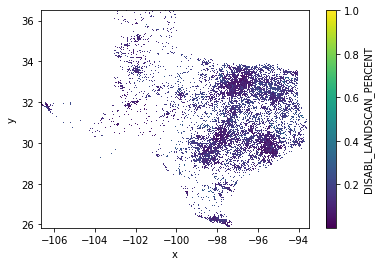

In [47]:
reload_pct.transpose().plot()

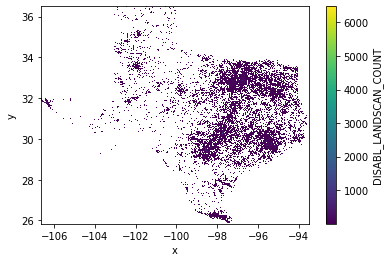

In [49]:
reload_disabl['DISABL_LANDSCAN_COUNT'].transpose().plot()

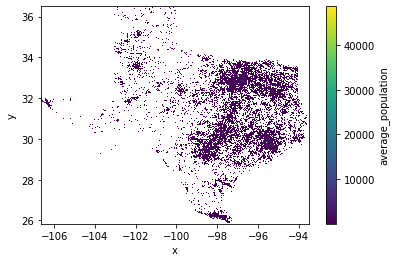

In [50]:
reload_disabl['average_population'].transpose().plot()

In [51]:
reload_disabl['average_population'].sum()

<xarray.DataArray 'average_population' ()>
array(28660297.)

In [52]:
reload_disabl['DISABL_LANDSCAN_COUNT'].sum()

<xarray.DataArray 'DISABL_LANDSCAN_COUNT' ()>
array(3283465.226)

## Resolution reduction for demographic variables

In [3]:
rdf_tract_svi = read_parquet('/home1/06134/kpierce/landscan/texas_3arcsec_tract_svi_join.parquet')

In [2]:
save_path_template = "/home1/06134/kpierce/landscan/{}_landscan_30arcsecond_masked_xr.nc"

In [3]:
calc_columns = ['10_14_MIN', '15_19_MIN', '20_24_MIN', '25_29_MIN', '30LESS_MIN',
       '30_34_MIN', '30_60_MIN', '35_39_MIN', '40_44_MIN', '45_59_MIN',
       '5LESS_MIN', '5_9_MIN', '60PLUS_MIN', '60_89_MIN', '90PLUS_MIN',
       'AGE17', 'AGE65', 'AMERICAN_INDIAN_ALASKA_NATIVE_ALONE', 'ASIAN_ALONE',
       'BLACK_AFRICAN_AMERICAN_ALONE', 'CROWD', 'DISABL', 'FOREIGN_BORN',
       'GROUPQ', 'HISPANIC_LATINO', 'LIMENG', 'MINRTY', 'MOBILE',
       'NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE', 'NOHSDP', 'NOVEH',
       'OTHER_RACE_ALONE', 'POV', 'RENTER_OCCUPIED_HU', 'TWO_OR_MORE_RACES',
       'UNEMP', 'UNINSUR', 'WHITE_ALONE', 'WHITE_ALONE_NOT_HISPANIC_LATINO']

In [6]:
coarse_xr_svi_list = []
for c in calc_columns:
    
    print(f'Processing column {c}.')
    
    c_out = svi_xarray(data=rdf_tract_svi, svi_column=c, save_template=save_path_template)
    coarse_xr_svi_list.append(c_out)

Processing column 10_14_MIN.
Processing column 15_19_MIN.
Processing column 20_24_MIN.
Processing column 25_29_MIN.
Processing column 30LESS_MIN.
Processing column 30_34_MIN.
Processing column 30_60_MIN.
Processing column 35_39_MIN.
Processing column 40_44_MIN.
Processing column 45_59_MIN.
Processing column 5LESS_MIN.
Processing column 5_9_MIN.
Processing column 60PLUS_MIN.
Processing column 60_89_MIN.
Processing column 90PLUS_MIN.
Processing column AGE17.
Processing column AGE65.
Processing column AMERICAN_INDIAN_ALASKA_NATIVE_ALONE.
Processing column ASIAN_ALONE.
Processing column BLACK_AFRICAN_AMERICAN_ALONE.
Processing column CROWD.
Processing column DISABL.
Processing column FOREIGN_BORN.
Processing column GROUPQ.
Processing column HISPANIC_LATINO.
Processing column LIMENG.
Processing column MINRTY.
Processing column MOBILE.
Processing column NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE.
Processing column NOHSDP.
Processing column NOVEH.
Processing column OTHER_RACE_ALONE.
Process

**Add in the values related to income.**

In [7]:
rdf_tract_dollars = read_parquet('/home1/06134/kpierce/landscan/texas_3arcsec_tract_dollars_join.parquet')

In [8]:
rdf_tract_dollars = rdf_tract_dollars.set_index(['x', 'y'])[['MEDIAN_GROSS_RENT_PCT_HH_INCOME', 'PCI']]

In [9]:
rdf_tract_dollars.head()

,,MEDIAN_GROSS_RENT_PCT_HH_INCOME,PCI
x,y,,
-95.444583,32.00125,23.2,27923.0
-95.445417,32.00125,23.2,27923.0
-95.446250,32.00125,23.2,27923.0
-95.447083,32.00125,23.2,27923.0
-95.447917,32.00125,23.2,27923.0


In [10]:
rdf_tract_dollars_xr = rdf_tract_dollars.to_xarray()

In [11]:
rdf_tract_dollars_xr

<xarray.Dataset>
Dimensions:                          (x: 15765, y: 12796)
Coordinates:
  * x                                (x) float64 -106.6 -106.6 ... -93.51 -93.51
  * y                                (y) float64 25.84 25.84 25.84 ... 36.5 36.5
Data variables:
    MEDIAN_GROSS_RENT_PCT_HH_INCOME  (x, y) float64 nan nan nan ... nan nan nan
    PCI                              (x, y) float64 nan nan nan ... nan nan nan

In [12]:
rdf_tract_dollars_xr_coarse = rdf_tract_dollars_xr.coarsen(
        boundary='pad',
        x=10,
        y=10,
    ).mean().compute()

In [14]:
rdf_tract_dollars_xr_coarse

<xarray.Dataset>
Dimensions:                          (x: 1577, y: 1280)
Coordinates:
  * x                                (x) float64 -106.6 -106.6 ... -93.52 -93.51
  * y                                (y) float64 25.84 25.85 ... 36.49 36.5
Data variables:
    MEDIAN_GROSS_RENT_PCT_HH_INCOME  (x, y) float64 nan nan nan ... nan nan nan
    PCI                              (x, y) float64 nan nan nan ... nan nan nan

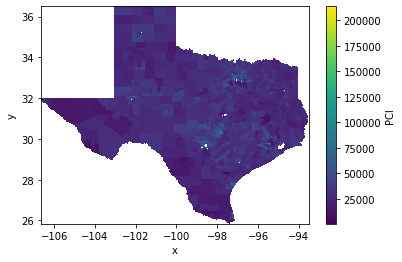

In [15]:
rdf_tract_dollars_xr['PCI'].transpose().plot()

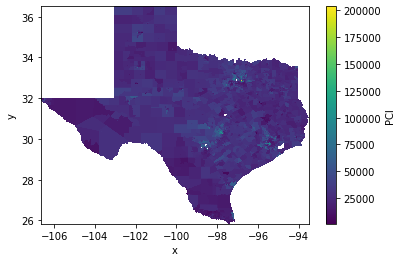

In [16]:
rdf_tract_dollars_xr_coarse['PCI'].transpose().plot()

In [25]:
rdf_tract_dollars_xr_coarse = rdf_tract_dollars_xr_coarse.where(rdf_tract_dollars_xr_coarse > 0)

In [26]:
rdf_tract_dollars_xr_coarse.to_netcdf('/home1/06134/kpierce/landscan/PCI_MEDIAN_HH_INCOME_PCT_RENT_landscan_30arcsecond_masked_xr.nc')


## Maniplate to different formats and export

In [4]:
calc_columns.append('PCI_MEDIAN_HH_INCOME_PCT_RENT')
svi_xr_paths = [save_path_template.format(c) for c in calc_columns]

In [5]:
svi_xr_datasets = [xr.open_dataset(p) for p in svi_xr_paths]

In [6]:
all_svi_xr = xr.merge(svi_xr_datasets)

In [7]:
all_svi_xr = all_svi_xr.where(all_svi_xr > 0)

In [8]:
all_svi_xr

<xarray.Dataset>
Dimensions:                                                        (x: 1577, y: 1280)
Coordinates:
  * x                                                              (x) float64 ...
  * y                                                              (y) float64 ...
Data variables: (12/81)
    average_population                                             (x, y) float64 ...
    10_14_MIN_LANDSCAN_COUNT                                       (x, y) float64 ...
    10_14_MIN_LANDSCAN_PERCENT                                     (x, y) float64 ...
    15_19_MIN_LANDSCAN_COUNT                                       (x, y) float64 ...
    15_19_MIN_LANDSCAN_PERCENT                                     (x, y) float64 ...
    20_24_MIN_LANDSCAN_COUNT                                       (x, y) float64 ...
    ...                                                             ...
    WHITE_ALONE_LANDSCAN_COUNT                                     (x, y) float64 ...
    WHITE_ALONE_LANDSCAN_PERCENT                                   (x, y) float64 ...
    WHITE_ALONE_NOT_HISPANIC_LATINO_LANDSCAN_COUNT                 (x, y) float64 ...
    WHITE_ALONE_NOT_HISPANIC_LATINO_LANDSCAN_PERCENT               (x, y) float64 ...
    MEDIAN_GROSS_RENT_PCT_HH_INCOME                                (x, y) float64 ...
    PCI                                                            (x, y) float64 ...

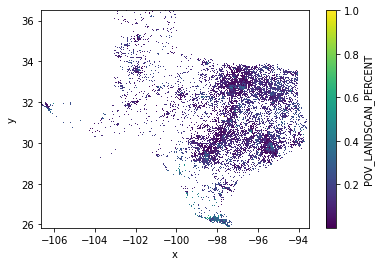

In [29]:
all_svi_xr['POV_LANDSCAN_PERCENT'].transpose().plot()

Make a unique index for each landscan cell and save it as a data variable in the xarray

In [51]:
all_svi_xr.sizes

Frozen({'x': 1577, 'y': 1280})

In [9]:
fishnet_id = np.array([i for i in range(all_svi_xr.sizes['x']*all_svi_xr.sizes['y'])]).reshape(all_svi_xr.sizes['x'], all_svi_xr.sizes['y'])

In [10]:
fishnet_id[0]

array([   0,    1,    2, ..., 1277, 1278, 1279])

In [11]:
all_svi_xr['fishnet_id'] = (['x', 'y'], fishnet_id)

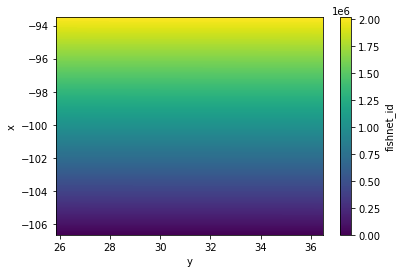

In [12]:
all_svi_xr['fishnet_id'].plot()

In [13]:
all_svi_xr

<xarray.Dataset>
Dimensions:                                                        (x: 1577, y: 1280)
Coordinates:
  * x                                                              (x) float64 ...
  * y                                                              (y) float64 ...
Data variables: (12/82)
    average_population                                             (x, y) float64 ...
    10_14_MIN_LANDSCAN_COUNT                                       (x, y) float64 ...
    10_14_MIN_LANDSCAN_PERCENT                                     (x, y) float64 ...
    15_19_MIN_LANDSCAN_COUNT                                       (x, y) float64 ...
    15_19_MIN_LANDSCAN_PERCENT                                     (x, y) float64 ...
    20_24_MIN_LANDSCAN_COUNT                                       (x, y) float64 ...
    ...                                                             ...
    WHITE_ALONE_LANDSCAN_PERCENT                                   (x, y) float64 ...
    WHITE_ALONE_NOT_HISPANIC_LATINO_LANDSCAN_COUNT                 (x, y) float64 ...
    WHITE_ALONE_NOT_HISPANIC_LATINO_LANDSCAN_PERCENT               (x, y) float64 ...
    MEDIAN_GROSS_RENT_PCT_HH_INCOME                                (x, y) float64 ...
    PCI                                                            (x, y) float64 ...
    fishnet_id                                                     (x, y) int64 ...

In [59]:
all_svi_xr = all_svi_xr.rio.write_crs('epsg:4326')

In [60]:
all_svi_xr.rio.crs

CRS.from_epsg(4326)

In [61]:
all_svi_xr.to_netcdf(path='/home1/06134/kpierce/landscan/all_svi_landscan_30arcsecond_masked_xr.nc')

In [15]:
all_svi_df = all_svi_xr.to_dataframe()

In [16]:
all_svi_df['average_population'].sum()

28660297.0

In [17]:
all_svi_df.shape

(2018560, 82)

In [18]:
all_svi_df_complete = all_svi_df[all_svi_df['average_population'] > 0]

In [19]:
all_svi_df_complete.to_csv('/home1/06134/kpierce/landscan/all_svi_landscan_30arcsecond_masked_df.csv')

In [20]:
all_svi_df_complete = all_svi_df_complete.reset_index()
all_svi_df_complete.head()

,x,y,average_population,10_14_MIN_LANDSCAN_COUNT,10_14_MIN_LANDSCAN_PERCENT,15_19_MIN_LANDSCAN_COUNT,15_19_MIN_LANDSCAN_PERCENT,20_24_MIN_LANDSCAN_COUNT,20_24_MIN_LANDSCAN_PERCENT,25_29_MIN_LANDSCAN_COUNT,...,UNEMP_LANDSCAN_PERCENT,UNINSUR_LANDSCAN_COUNT,UNINSUR_LANDSCAN_PERCENT,WHITE_ALONE_LANDSCAN_COUNT,WHITE_ALONE_LANDSCAN_PERCENT,WHITE_ALONE_NOT_HISPANIC_LATINO_LANDSCAN_COUNT,WHITE_ALONE_NOT_HISPANIC_LATINO_LANDSCAN_PERCENT,MEDIAN_GROSS_RENT_PCT_HH_INCOME,PCI,fishnet_id
0,-106.641667,31.891667,2.0,0.229469,0.114734,0.148551,0.074275,0.282609,0.141304,0.195652,...,0.051,0.084,0.042,1.553237,0.776619,0.376672,0.188336,25.5,33080.0,726
1,-106.641667,31.900000,112.0,12.850242,0.114734,8.318841,0.074275,15.826087,0.141304,10.956522,...,0.051,4.704,0.042,86.981273,0.776619,21.093633,0.188336,25.5,33080.0,727
2,-106.641667,31.908333,18.0,2.065217,0.114734,1.336957,0.074275,2.543478,0.141304,1.760870,...,0.051,0.756,0.042,13.979133,0.776619,3.390048,0.188336,25.5,33080.0,728
3,-106.633333,31.866667,257.0,45.064023,0.175346,45.248208,0.176063,39.415671,0.153368,21.733875,...,0.026,33.667,0.131,234.617240,0.912908,55.182113,0.214716,26.7,32948.0,2003
4,-106.633333,31.875000,200.0,35.069279,0.175346,35.212613,0.176063,30.673674,0.153368,16.913521,...,0.026,26.200,0.131,182.581510,0.912908,42.943278,0.214716,26.7,32948.0,2004


In [23]:
all_svi_df_complete.shape

(231939, 85)

In [24]:
len(all_svi_df_complete['fishnet_id'].unique())

231939

In [25]:
svi_points = gpd.points_from_xy(all_svi_df_complete['x'], all_svi_df_complete['y'])
all_svi_shp_complete = gpd.GeoDataFrame(
    all_svi_df_complete,
    geometry=svi_points,
    crs='epsg:4326' # known from other files not currently loaded in memory
)

In [26]:
all_svi_shp_complete.to_file('/home1/06134/kpierce/landscan/all_svi_landscan_30arcsecond_masked.shp')

/home1/06134/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


## Create a landscan 30 arcsecond fishnet

This conversion from raster to polygon can be used for point-in-polygon joins on maltreatment data.

This seems like a roundabout workflow, but saving the landscan only raster as a GeoTIFF allows us to access its resolution and CRS attributes. This helps with data portability and self-documentation.

In [16]:
all_svi_xr_reload = xr.open_dataset('/home1/06134/kpierce/landscan/all_svi_landscan_30arcsecond_masked_xr.nc')

In [39]:
all_svi_xr_reload.rio.resolution()

(0.00833201138799175, 0.008332030198623918)

In [17]:
all_svi_xr_reload

<xarray.Dataset>
Dimensions:                                                        (x: 1577, y: 1280)
Coordinates:
  * x                                                              (x) float64 ...
  * y                                                              (y) float64 ...
Data variables: (12/82)
    average_population                                             (x, y) float64 ...
    10_14_MIN_LANDSCAN_COUNT                                       (x, y) float64 ...
    10_14_MIN_LANDSCAN_PERCENT                                     (x, y) float64 ...
    15_19_MIN_LANDSCAN_COUNT                                       (x, y) float64 ...
    15_19_MIN_LANDSCAN_PERCENT                                     (x, y) float64 ...
    20_24_MIN_LANDSCAN_COUNT                                       (x, y) float64 ...
    ...                                                             ...
    WHITE_ALONE_LANDSCAN_PERCENT                                   (x, y) float64 ...
    WHITE_ALONE_NOT_HISPANIC_LATINO_LANDSCAN_COUNT                 (x, y) float64 ...
    WHITE_ALONE_NOT_HISPANIC_LATINO_LANDSCAN_PERCENT               (x, y) float64 ...
    MEDIAN_GROSS_RENT_PCT_HH_INCOME                                (x, y) float64 ...
    PCI                                                            (x, y) float64 ...
    fishnet_id                                                     (x, y) int64 ...

In [18]:
landscan_only = all_svi_xr_reload[['x', 'y', 'average_population', 'fishnet_id']]

In [19]:
landscan_only

<xarray.Dataset>
Dimensions:             (x: 1577, y: 1280)
Coordinates:
  * x                   (x) float64 -106.6 -106.6 -106.6 ... -93.52 -93.51
  * y                   (y) float64 25.84 25.85 25.86 25.87 ... 36.48 36.49 36.5
Data variables:
    average_population  (x, y) float64 ...
    fishnet_id          (x, y) int64 ...

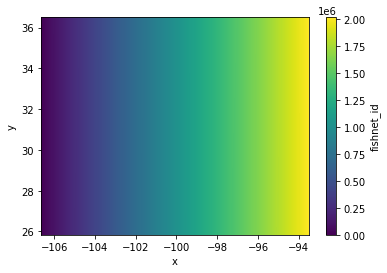

In [20]:
landscan_only['fishnet_id'].transpose().plot()

In [21]:
landscan_only = landscan_only.rio.write_crs('epsg:4326')

In [22]:
landscan_only.rio.crs

CRS.from_epsg(4326)

In [23]:
type(landscan_only)

xarray.core.dataset.Dataset

In [24]:
landscan_only

<xarray.Dataset>
Dimensions:             (x: 1577, y: 1280)
Coordinates:
  * x                   (x) float64 -106.6 -106.6 -106.6 ... -93.52 -93.51
  * y                   (y) float64 25.84 25.85 25.86 25.87 ... 36.48 36.49 36.5
    spatial_ref         int64 0
Data variables:
    average_population  (x, y) float64 ...
    fishnet_id          (x, y) int64 ...

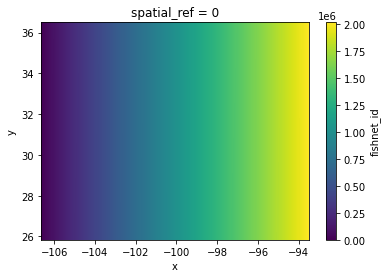

In [25]:
landscan_only['fishnet_id'].transpose().plot()

In [20]:
rioxarray.__version__

'0.7.0'

In [26]:
landscan_only.rio.crs

CRS.from_epsg(4326)

In [28]:
landscan_only.fillna(0).transpose().rio.to_raster(
    '/home1/06134/kpierce/landscan/landscan_30arcsecond_masked.tif',
)


In [29]:
import rasterio

In [30]:
landscan_reload = rioxarray.open_rasterio(
    '/home1/06134/kpierce/landscan/landscan_30arcsecond_masked.tif', masked=True,
    chunks=10
)

In [31]:
landscan_reload.rio.crs

CRS.from_epsg(4326)

In [32]:
landscan_reload

,Array,Chunk
Bytes,30.80 MiB,1.56 kiB
Shape,"(2, 1280, 1577)","(2, 10, 10)"
Count,20225 Tasks,20224 Chunks
Type,float64,numpy.ndarray


In [33]:
landscan_reload.rio.resolution()

(0.00833201138799175, 0.008332030198623918)

We can see from above the fishnet ID is saved as the second band in the dataset. We convert only those values to a dataframe.

In [37]:
landscan_reload_df = landscan_reload.sel(dict(band=2)).to_dataframe(name='fishnet_id').reset_index()

In [38]:
landscan_reload_df.head()

,y,x,band,spatial_ref,fishnet_id
0,25.841667,-106.641667,2,0,0.0
1,25.841667,-106.633335,2,0,1280.0
2,25.841667,-106.625003,2,0,2560.0
3,25.841667,-106.616671,2,0,3840.0
4,25.841667,-106.608339,2,0,5120.0


In [40]:
x_resolution = landscan_reload.rio.resolution()[0]
y_resolution = landscan_reload.rio.resolution()[1]

In [41]:
landscan_reload_df['x_min'] = landscan_reload_df['x'] - (x_resolution / 2)
landscan_reload_df['x_max'] = landscan_reload_df['x'] + (x_resolution / 2)
landscan_reload_df['y_min'] = landscan_reload_df['y'] - (y_resolution / 2)
landscan_reload_df['y_max'] = landscan_reload_df['y'] + (y_resolution / 2)

In [42]:
landscan_reload_df.head()

,y,x,band,spatial_ref,fishnet_id,x_min,x_max,y_min,y_max
0,25.841667,-106.641667,2,0,0.0,-106.645833,-106.637501,25.837501,25.845833
1,25.841667,-106.633335,2,0,1280.0,-106.637501,-106.629169,25.837501,25.845833
2,25.841667,-106.625003,2,0,2560.0,-106.629169,-106.620837,25.837501,25.845833
3,25.841667,-106.616671,2,0,3840.0,-106.620837,-106.612505,25.837501,25.845833
4,25.841667,-106.608339,2,0,5120.0,-106.612505,-106.604173,25.837501,25.845833


In [43]:
from shapely.geometry import Polygon

In [44]:
landscan_reload_df['geometry'] = [
    Polygon([
        (row['x_min'], row['y_min']),
        (row['x_min'], row['y_max']),
        (row['x_max'], row['y_max']),
        (row['x_max'], row['y_min'])]) for i, row in landscan_reload_df.iterrows()
    ]

In [45]:
landscan_reload_df.head()

,y,x,band,spatial_ref,fishnet_id,x_min,x_max,y_min,y_max,geometry
0,25.841667,-106.641667,2,0,0.0,-106.645833,-106.637501,25.837501,25.845833,"POLYGON ((-106.645832745794 25.8375006452007, ..."
1,25.841667,-106.633335,2,0,1280.0,-106.637501,-106.629169,25.837501,25.845833,"POLYGON ((-106.637500734406 25.8375006452007, ..."
2,25.841667,-106.625003,2,0,2560.0,-106.629169,-106.620837,25.837501,25.845833,"POLYGON ((-106.629168723018 25.8375006452007, ..."
3,25.841667,-106.616671,2,0,3840.0,-106.620837,-106.612505,25.837501,25.845833,"POLYGON ((-106.62083671163 25.8375006452007, -..."
4,25.841667,-106.608339,2,0,5120.0,-106.612505,-106.604173,25.837501,25.845833,"POLYGON ((-106.612504700242 25.8375006452007, ..."


In [46]:
landscan_gdf = gpd.GeoDataFrame(landscan_reload_df, geometry=landscan_reload_df['geometry'], crs=landscan_reload.rio.crs)

In [53]:
landscan_gdf.head()

,y,x,band,spatial_ref,fishnet_id,x_min,x_max,y_min,y_max,geometry
0,25.841667,-106.641667,2,0,0.0,-106.645833,-106.637501,25.837501,25.845833,"POLYGON ((-106.64583 25.83750, -106.64583 25.8..."
1,25.841667,-106.633335,2,0,1280.0,-106.637501,-106.629169,25.837501,25.845833,"POLYGON ((-106.63750 25.83750, -106.63750 25.8..."
2,25.841667,-106.625003,2,0,2560.0,-106.629169,-106.620837,25.837501,25.845833,"POLYGON ((-106.62917 25.83750, -106.62917 25.8..."
3,25.841667,-106.616671,2,0,3840.0,-106.620837,-106.612505,25.837501,25.845833,"POLYGON ((-106.62084 25.83750, -106.62084 25.8..."
4,25.841667,-106.608339,2,0,5120.0,-106.612505,-106.604173,25.837501,25.845833,"POLYGON ((-106.61250 25.83750, -106.61250 25.8..."


In [56]:
landscan_gdf.to_csv('/work2/06134/kpierce/frontera/landscan/landscan/landscan_30arcsecond_with_fishnet_id.csv')

In [58]:
landscan_gdf.to_file('/work2/06134/kpierce/frontera/landscan/landscan/landscan_30arcsecond_with_fishnet_id.shp')

/home1/06134/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.
